In [98]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

In [68]:
df = pd.read_csv('/Users/arun/Downloads/HR_comma_sep.csv')

In [69]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Initial EDA and data cleaning

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [71]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [72]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [73]:
df.duplicated().sum()

np.int64(3008)

In [74]:
df[df.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [75]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [76]:
df = df.rename(columns={
    'average_montly_hours' : 'average_monthly_hours',
    'time_spend_company' : 'tenure',
    'Work_accident' : 'work_accident',
    'Department' : 'department'
})

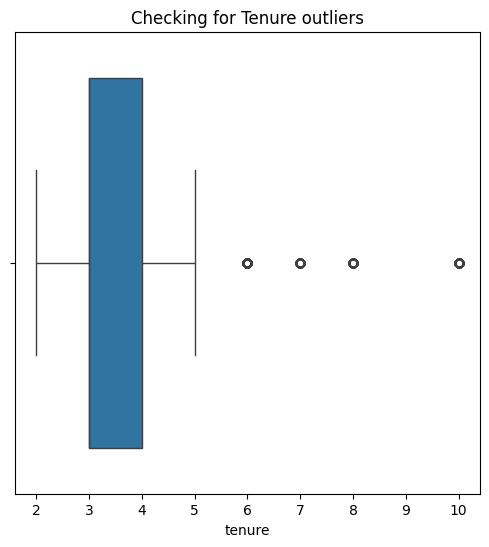

In [77]:
plt.figure(figsize=(6,6))
plt.title('Checking for Tenure outliers', fontsize = 12)
sns.boxplot(x=df['tenure'])
plt.show()

In [78]:
# Check for number of outliers

percentile25 = df['tenure'].quantile(0.25)
percentile75 = df['tenure'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + iqr*1.5
lower_limit = percentile25 - iqr*1.5
print(f'Lower Limit: {lower_limit}')
print(f'Upper Limit: {upper_limit}')
outliers = df[(df['tenure'] < lower_limit) | (df['tenure'] > upper_limit)]
print('No. of outliers in tenure is:',len(outliers))

Lower Limit: 1.5
Upper Limit: 5.5
No. of outliers in tenure is: 824


In [79]:
df['left'].value_counts(normalize = True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

Plotting Visualizations

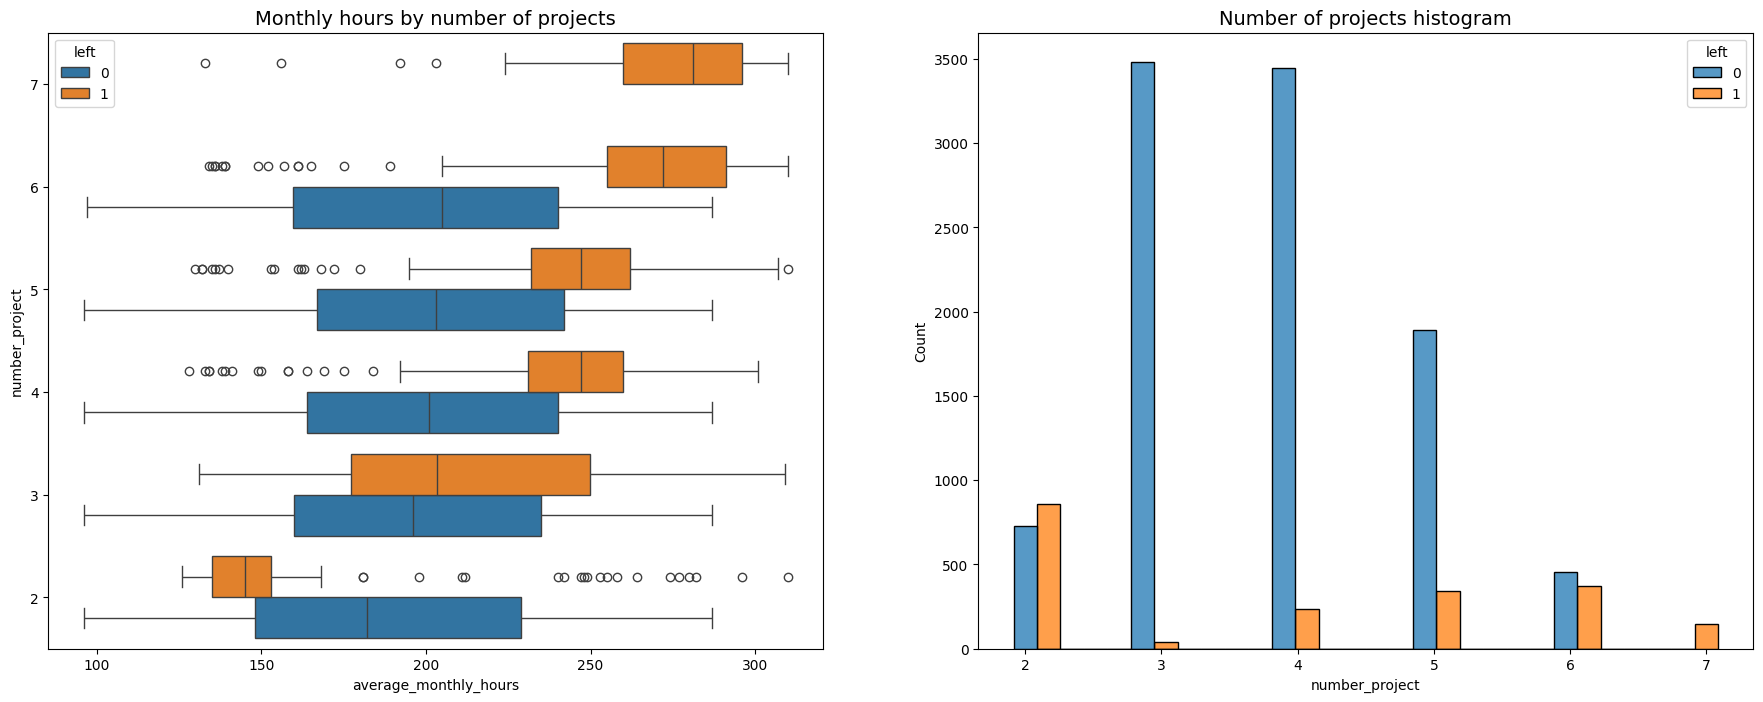

In [80]:


fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=df, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

tenure_stay = df[df['left']==0]['number_project']
tenure_left = df[df['left']==1]['number_project']
sns.histplot(data=df, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')
plt.show()

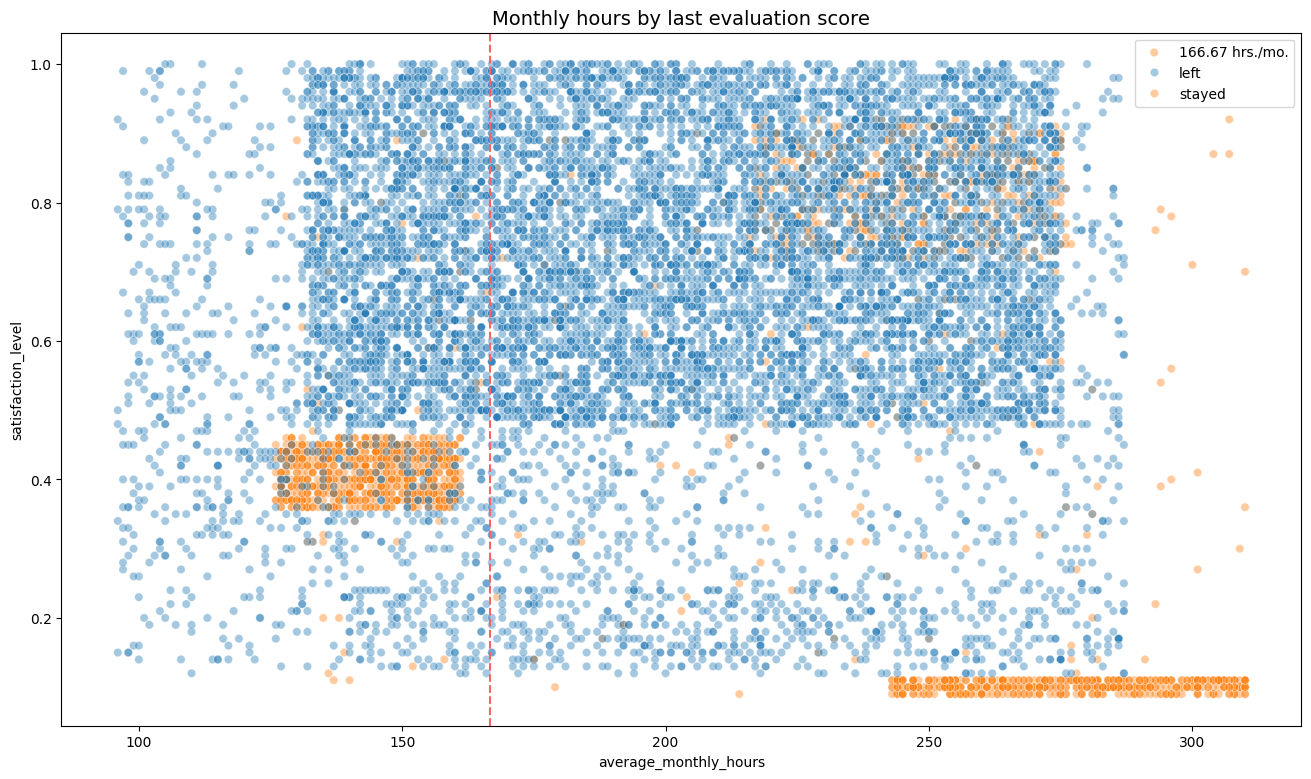

In [81]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

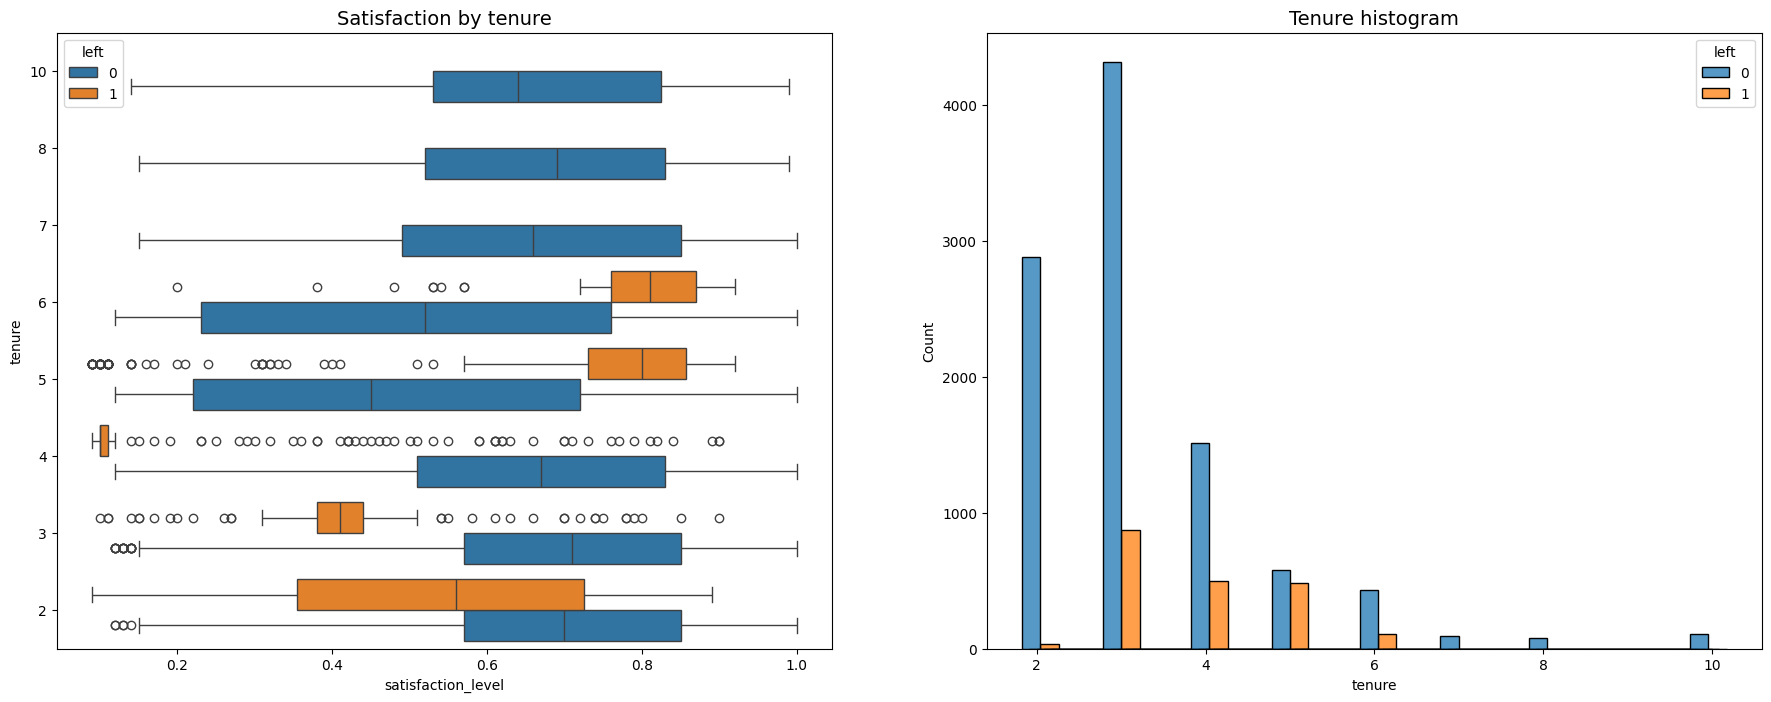

In [82]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=df, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

sns.histplot(data=df, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

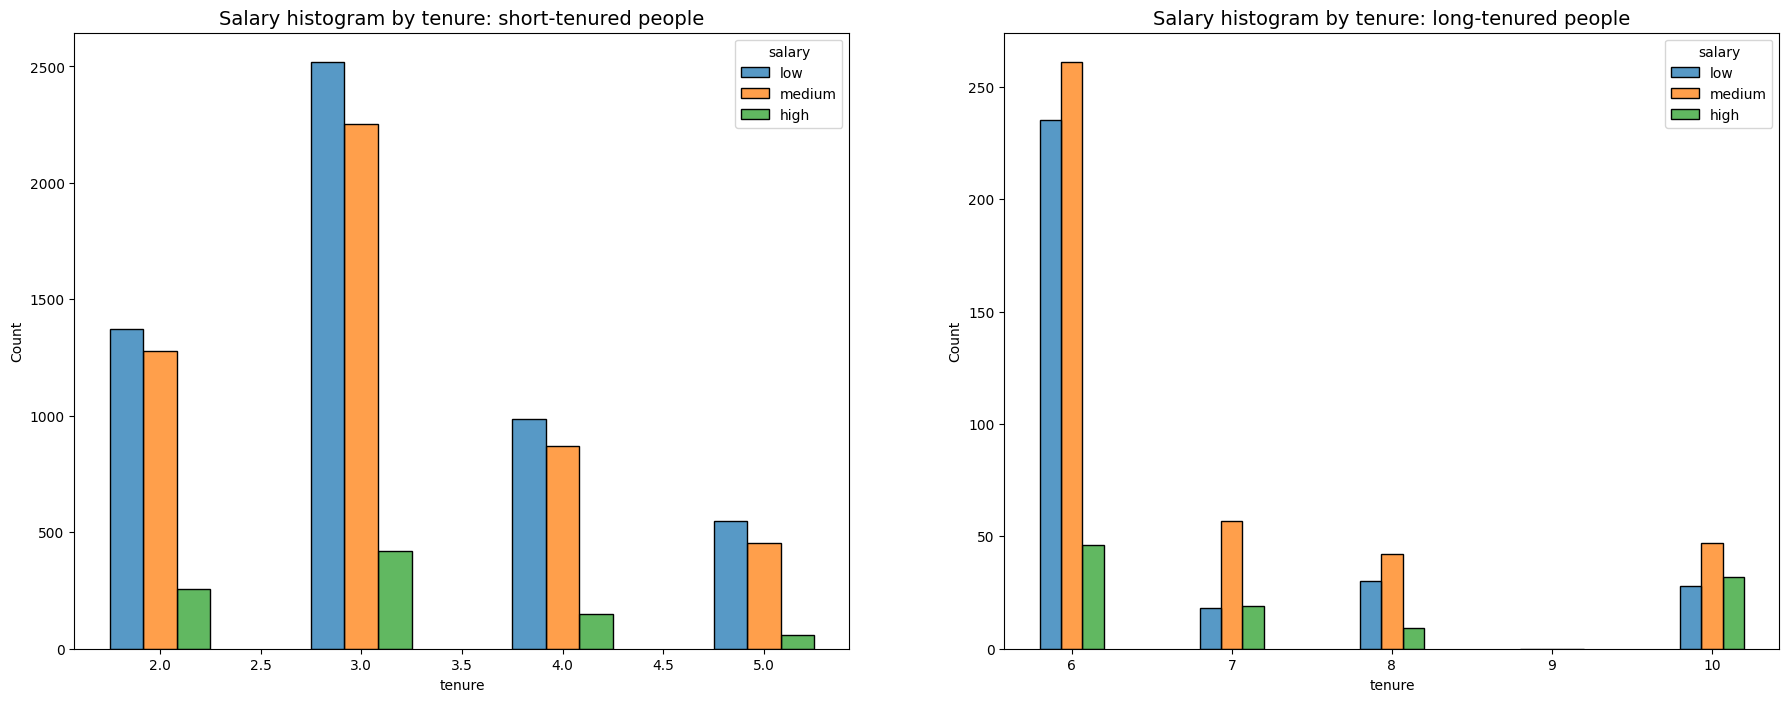

In [83]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees
tenure_short = df[df['tenure'] < 6]

# Define long-tenured employees
tenure_long = df[df['tenure'] > 5]

sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

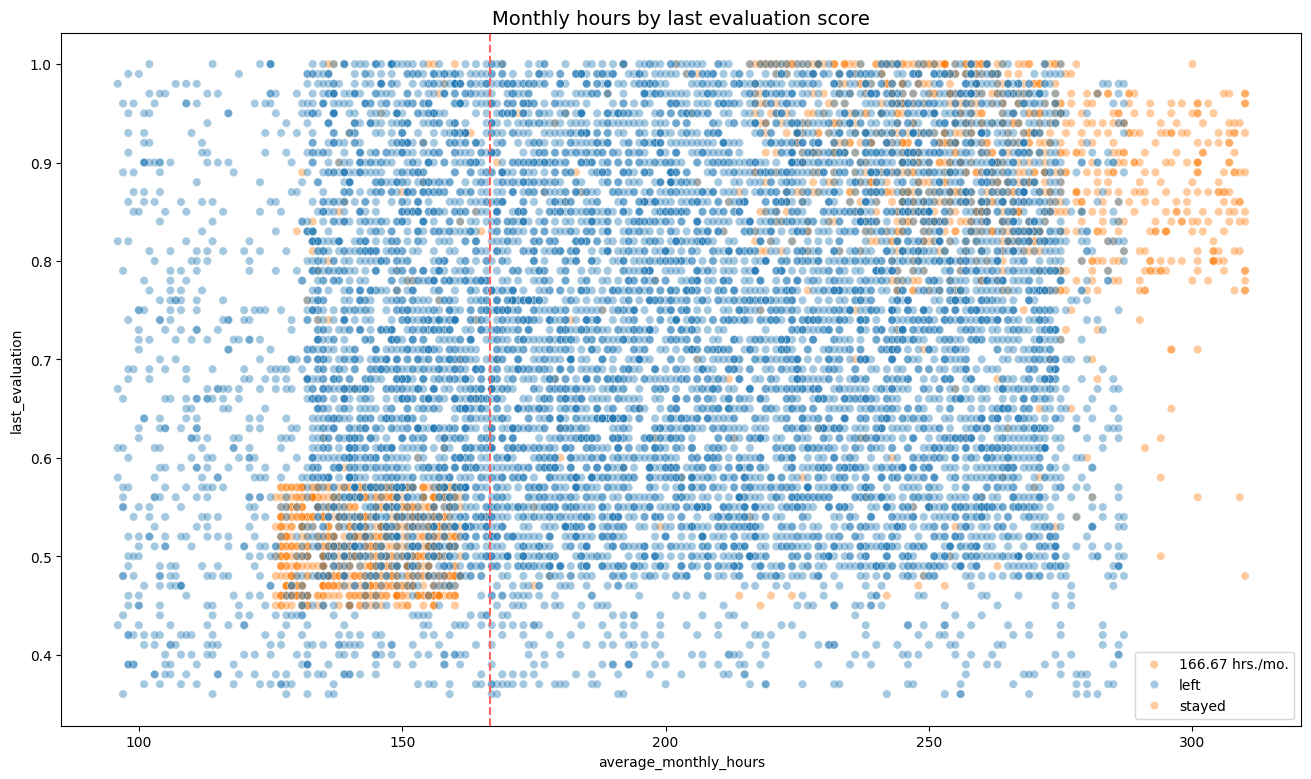

In [84]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

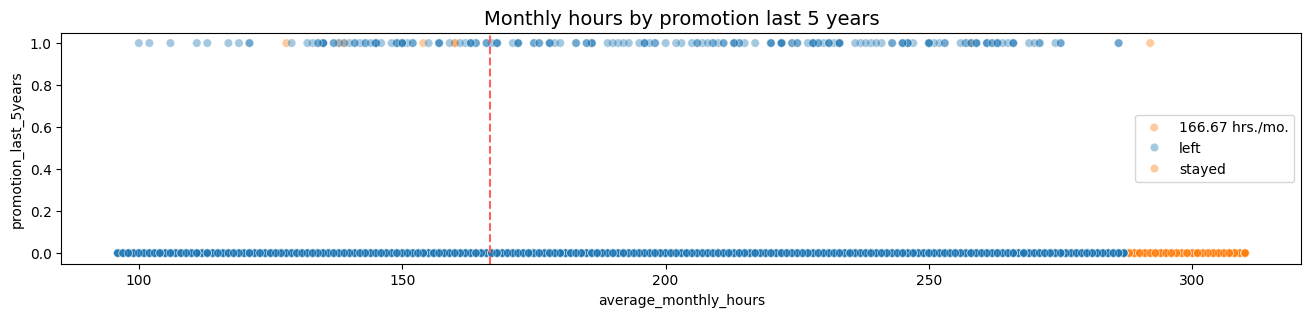

In [85]:
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

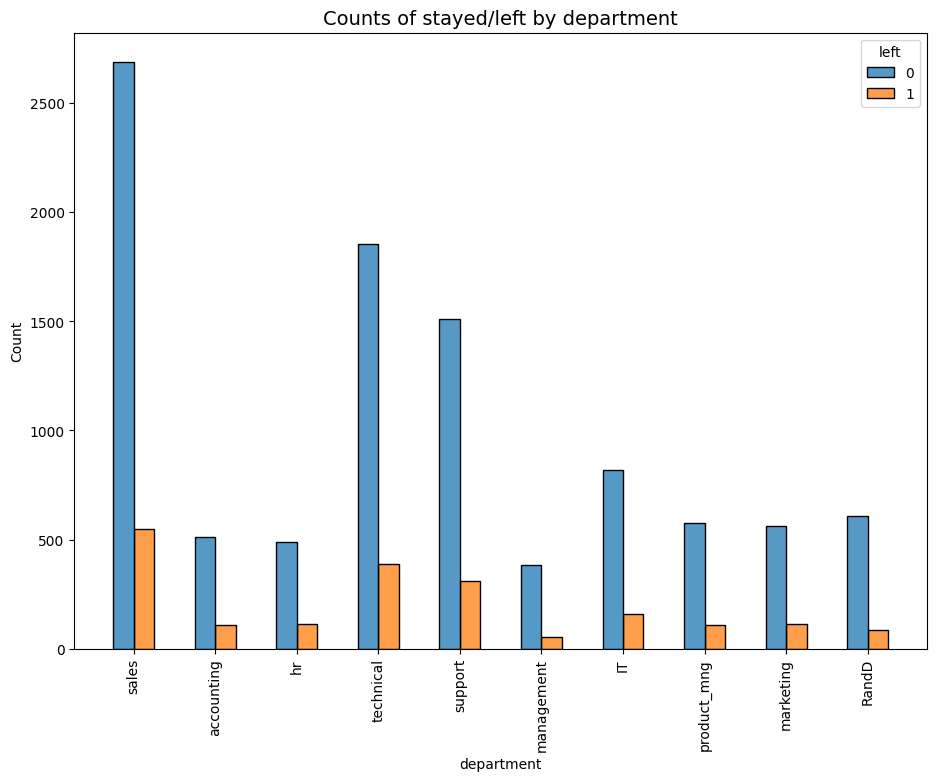

In [86]:
plt.figure(figsize=(11,8))
sns.histplot(data=df, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation='vertical')
plt.title('Counts of stayed/left by department', fontsize=14);

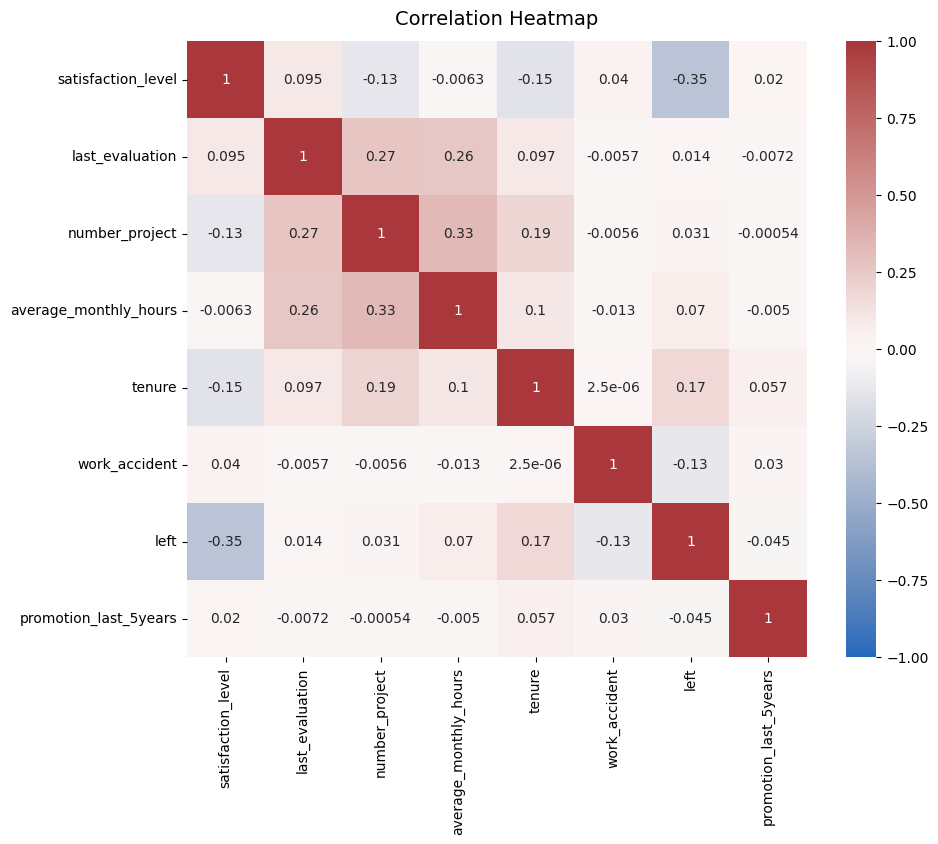

In [87]:
#check for correlations

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

Building Logistic Regression Model

In [88]:
df_enc = df.copy()

In [89]:
#converting categorical variables to numerals

df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

df_enc = pd.get_dummies(df_enc, drop_first=False)

columns_to_convert = ['department_IT',                
'department_RandD',           
'department_accounting',       
'department_hr',            
'department_management',    
'department_marketing',
'department_product_mng', 
'department_sales',           
'department_support',          
'department_technical']
df_enc[columns_to_convert] = df_enc[columns_to_convert].astype(int)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


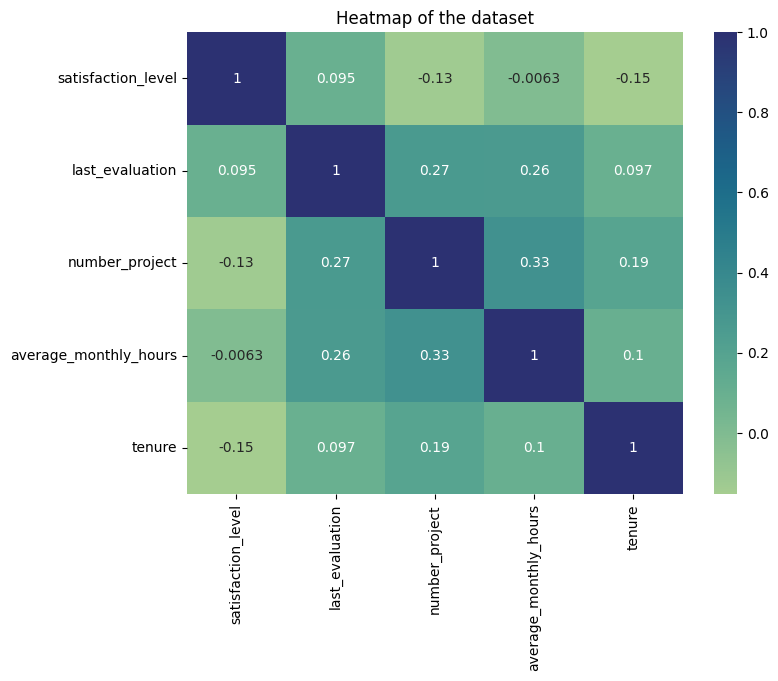

In [90]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

In [91]:
# Since Logistic Regression is sensitive to outliers, removing them
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]


In [92]:
y = df_logreg['left']
X = df_logreg.drop('left',axis=1)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.25, stratify=y, random_state=42)

In [94]:
log_clf = LogisticRegression(random_state=42, max_iter=5000).fit(X_train, y_train)

In [95]:
y_pred = log_clf.predict(X_test)

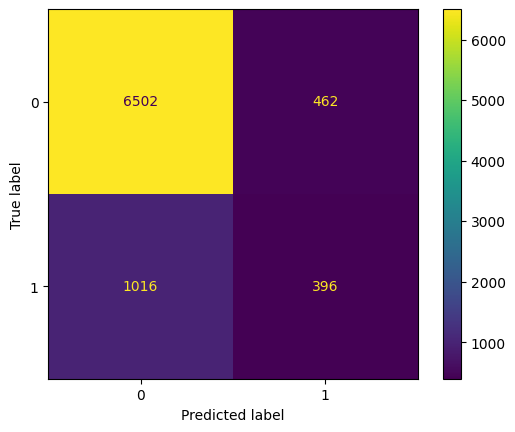

In [96]:
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)
log_disp.plot(values_format='')
plt.show()

In [97]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      6964
    Predicted would leave       0.46      0.28      0.35      1412

                 accuracy                           0.82      8376
                macro avg       0.66      0.61      0.62      8376
             weighted avg       0.80      0.82      0.81      8376



Tree-Based Model